# IMPORTS

In [1]:
import os

import pandas as pd
pd.options.display.max_columns = None

import numpy as np
import plotly.express as px

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statistics import mean
from scipy import signal

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from scipy.fft import fft

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from dateutil.relativedelta import relativedelta
from datetime import datetime

import sys


from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaberta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anaberta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# OBTENCIÓN DE DATOS

In [2]:
df_noticias_pais = pd.read_csv('Data/df_noticias_pais.csv')
df_noticias_region = pd.read_csv('Data/df_noticias_region.csv')

In [3]:
df_noticias_pais.head(2)

,id,title,slug,subcategory,category,published,tags,País,Usuarios activos,Usuarios recurrentes,Sesiones,Vistas,Vistas por usuario activo,Vistas por sesión,Tiempo de interacción medio por usuario activo,Duración media de la sesión,Porcentaje de rebote
0,168132,Cerco a las viviendas turísticas: las nuevas n...,168132_cerco-a-las-viviendas-turisticas-las-nu...,Actualidad hotelera,Hoteles y Alojamientos,2025-01-31,"alquiler turístico, Ayuntamiento de Granada, A...",Argentina,12.0,10.0,19.0,22.0,1.833333,1.157895,158.75,56.680664,0.157895
1,168132,Cerco a las viviendas turísticas: las nuevas n...,168132_cerco-a-las-viviendas-turisticas-las-nu...,Actualidad hotelera,Hoteles y Alojamientos,2025-01-31,"alquiler turístico, Ayuntamiento de Granada, A...",Australia,2.0,1.0,3.0,4.0,2.000000,1.333333,28.50,101.715149,0.000000


In [4]:
df_noticias_pais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448039 entries, 0 to 448038
Data columns (total 17 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   id                                              448039 non-null  int64  
 1   title                                           448039 non-null  object 
 2   slug                                            448039 non-null  object 
 3   subcategory                                     448039 non-null  object 
 4   category                                        448039 non-null  object 
 5   published                                       448039 non-null  object 
 6   tags                                            445467 non-null  object 
 7   País                                            448039 non-null  object 
 8   Usuarios activos                                448039 non-null  float64
 9   Usuarios recurrentes      

In [5]:
df_noticias_region.head(2)

,id,title,slug,subcategory,category,published,tags,Región,Usuarios activos,Usuarios recurrentes,Sesiones,Vistas,Vistas por usuario activo,Vistas por sesión,Tiempo de interacción medio por usuario activo,Duración media de la sesión,Porcentaje de rebote
0,168132,Cerco a las viviendas turísticas: las nuevas n...,168132_cerco-a-las-viviendas-turisticas-las-nu...,Actualidad hotelera,Hoteles y Alojamientos,2025-01-31,"alquiler turístico, Ayuntamiento de Granada, A...",Andalusia,137.0,83.0,170.0,169.0,1.221253,0.914434,82.321178,74.193478,0.077140
1,168132,Cerco a las viviendas turísticas: las nuevas n...,168132_cerco-a-las-viviendas-turisticas-las-nu...,Actualidad hotelera,Hoteles y Alojamientos,2025-01-31,"alquiler turístico, Ayuntamiento de Granada, A...",Aragon,11.0,7.0,17.0,13.0,1.370370,0.633333,69.777778,61.345131,0.333333


In [6]:
df_noticias_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325793 entries, 0 to 325792
Data columns (total 17 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   id                                              325793 non-null  int64  
 1   title                                           325793 non-null  object 
 2   slug                                            325793 non-null  object 
 3   subcategory                                     325793 non-null  object 
 4   category                                        325793 non-null  object 
 5   published                                       325793 non-null  object 
 6   tags                                            323528 non-null  object 
 7   Región                                          325793 non-null  object 
 8   Usuarios activos                                325793 non-null  float64
 9   Usuarios recurrentes      

In [7]:
# Convertir la columna a datetime
df_noticias_pais['published'] = pd.to_datetime(df_noticias_pais['published'])
df_noticias_region['published'] = pd.to_datetime(df_noticias_region['published'])

# ANÁLISIS DE DATOS

In [36]:
def plot_views_by_region(df: pd.DataFrame, region_col: str, views_col: str):
    """
    Genera un gráfico de barras del total de vistas por región a partir de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame de entrada que contiene los datos de noticias.
        region_col (str): El nombre de la columna que contiene la información de la región.
        views_col (str): El nombre de la columna que contiene el número de vistas.
    """
    # Validaciones básicas para asegurar que los inputs son correctos
    if not isinstance(df, pd.DataFrame):
        raise TypeError("El primer argumento debe ser un DataFrame de pandas.")
    if region_col not in df.columns:
        raise ValueError(f"La columna '{region_col}' no se encuentra en el DataFrame.")
    if views_col not in df.columns:
        raise ValueError(f"La columna '{views_col}' no se encuentra en el DataFrame.")
    
    # Intentar convertir la columna de vistas a numérica si no lo es
    if not pd.api.types.is_numeric_dtype(df[views_col]):
        print(f"Advertencia: La columna '{views_col}' no es numérica. Se intentará convertir.")
        try:
            df[views_col] = pd.to_numeric(df[views_col], errors='coerce')
            if df[views_col].isnull().any():
                print(f"Advertencia: Algunos valores en '{views_col}' no pudieron convertirse a numéricos y se han establecido como NaN.")
        except Exception as e:
            raise TypeError(f"No se pudo convertir la columna '{views_col}' a numérica: {e}")

    # 1. Agrupar por la columna de región y sumar las vistas
    df_grouped = df.groupby(region_col)[views_col].sum().reset_index()

    # 2. Crear la gráfica de barras
    plt.figure(figsize=(30, 10))
    plt.bar(df_grouped[region_col], df_grouped[views_col], color='skyblue')

    # 3. Personalizar el gráfico
    plt.xlabel(region_col.replace('_', ' ').title()) # Etiqueta del eje X
    plt.ylabel(views_col.replace('_', ' ').title()) # Etiqueta del eje Y
    plt.title(f'Total de {views_col.replace("_", " ").title()} por {region_col.replace("_", " ").title()}') # Título del gráfico
    plt.xticks(rotation=45, ha='right') # Rota las etiquetas del eje X para mejor legibilidad
    plt.tight_layout() # Ajusta el diseño para que todo encaje bien

    # Mostrar el gráfico
    plt.show()

## Noticias por paises

In [8]:
df_noticias_pais.id.value_counts()

id
159295    170
156939    150
161186    136
157429    129
158406    127
         ... 
146877      1
146884      1
140703      1
136601      1
148628      1
Name: count, Length: 24878, dtype: int64

In [9]:
df_noticias_pais.title.value_counts()

title
Las tres noticias más importantes del sector turístico hoy                     209
Marina d'Or cancela todas las reservas y cierra sus hoteles                    170
Los 16 pasaportes más poderosos del mundo                                      150
Los pasaportes con mayor rango de poder del mundo. España en el top            136
Ranking de las mejores marcas de ciudades del mundo. Hay dos españolas         129
                                                                              ... 
La hotelería española busca afianzar la rentabilidad ante la desescalada         1
Amadeus registró en junio su mejor mes desde el inicio de la pandemia            1
United empieza a volar Nueva York-Londres con test COVID obligatorio             1
Vuelos procedentes de China, Portugal, Francia e Italia aumentarán en junio      1
Transavia inicia una nueva ruta entre España y Francia                           1
Name: count, Length: 24811, dtype: int64

In [10]:
df_noticias_pais.slug.value_counts()

slug
159295_marina-dor-cancela-todas-las-reservas-y-cierra-todos-sus-hoteles              170
156939_los-16-pasaportes-mas-poderosos-del-mundo                                     150
161186_seis-paises-con-el-pasaporte-mas-poderoso-del-mundo-en-2024                   136
157429_ranking-de-las-100-mejores-ciudades-del-mundo                                 129
158406_nueva-burocracia-de-entrada-en-europa-para-2024-estamos-preparados            127
                                                                                    ... 
146877_binter-vuelve-anular-sus-vuelos-a-la-palma-aunque-el-aeropuerto-si-opera        1
146884_permitir-formulas-de-devolucion-mas-flexibles-ayudaria-a-las-agencias           1
140703_la-mayoria-de-ayuntamientos-ni-perdonan-ni-rebajan-impuestos-a-los-hoteles      1
136601_servigroup-prepara-la-reapertura-de-sus-hoteles-el-1-de-julio                   1
148628_canarian-hospitality-inaugura-manana-su-primer-hotel-en-adeje                   1
Name: count, Len

In [11]:
df_noticias_pais.subcategory.value_counts()

subcategory
Actualidad turística                                     92915
Actualidad hotelera                                      70434
Actualidad e intermediación                              61881
Actualidad                                               25864
Aperturas y cierres de hoteles                           23855
Compañías aéreas                                         23478
Industria, business y nuevas tendencias                  14415
Aeropuertos                                              11662
Innovación hotelera                                       9152
Estadísticas e informes                                   8886
Transacciones hoteleras                                   8322
Gestión de destinos turísticos                            7651
Ferroviario                                               7202
Cruceros                                                  6982
Gestión hotelera                                          5532
Tendencias                                 

In [12]:
df_noticias_pais.category.value_counts()

category
Hoteles y Alojamientos    137526
Economía                  118221
Transportes                96046
Distribución               78672
Innovación                 17574
Name: count, dtype: int64

<Axes: ylabel='count'>

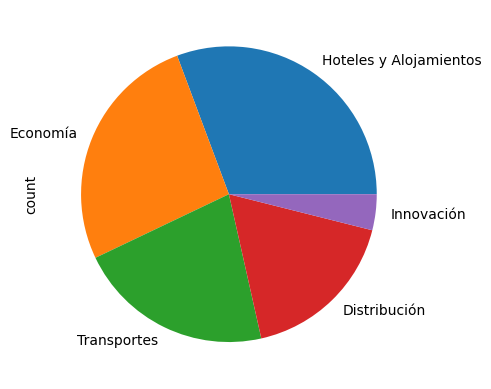

In [13]:
df_noticias_pais.category.value_counts().plot(kind="pie")

In [14]:
df_noticias_pais.published.value_counts()

published
2022-09-21    941
2024-06-13    917
2022-09-14    813
2022-08-30    809
2024-01-15    751
             ... 
2020-03-29      3
2020-09-19      3
2020-04-12      2
2020-09-20      2
2020-08-01      2
Name: count, Length: 1857, dtype: int64

In [15]:
df_noticias_pais.published.describe()

count                           448039
mean     2023-05-09 19:55:55.703409920
min                2020-01-01 00:00:00
25%                2022-09-15 00:00:00
50%                2023-06-23 00:00:00
75%                2024-04-09 00:00:00
max                2025-01-31 00:00:00
Name: published, dtype: object

In [16]:
df_noticias_pais.tags.value_counts()

tags
Noticias turismo hoy                                                                                                                                                                                1401
Publi Noticia Hosteltur                                                                                                                                                                             1247
Travelgate                                                                                                                                                                                           692
CONTENIDO PARA AAVV                                                                                                                                                                                  401
actualidad turística, Noticias turismo hoy, Tendencias turismo                                                                                                                                 

In [17]:
df_noticias_pais["País"].value_counts()

País
Mexico            19585
Argentina         17415
Colombia          15907
France            15210
United Kingdom    14711
                  ...  
Vatican City          2
Antarctica            2
Tonga                 1
American Samoa        1
North Korea           1
Name: count, Length: 226, dtype: int64

In [18]:
df_noticias_pais["Vistas"].value_counts()

Vistas
1.0       174953
2.0        80345
3.0        43172
4.0        27583
5.0        18875
           ...  
359.0          1
724.0          1
355.0          1
499.0          1
1559.0         1
Name: count, Length: 812, dtype: int64

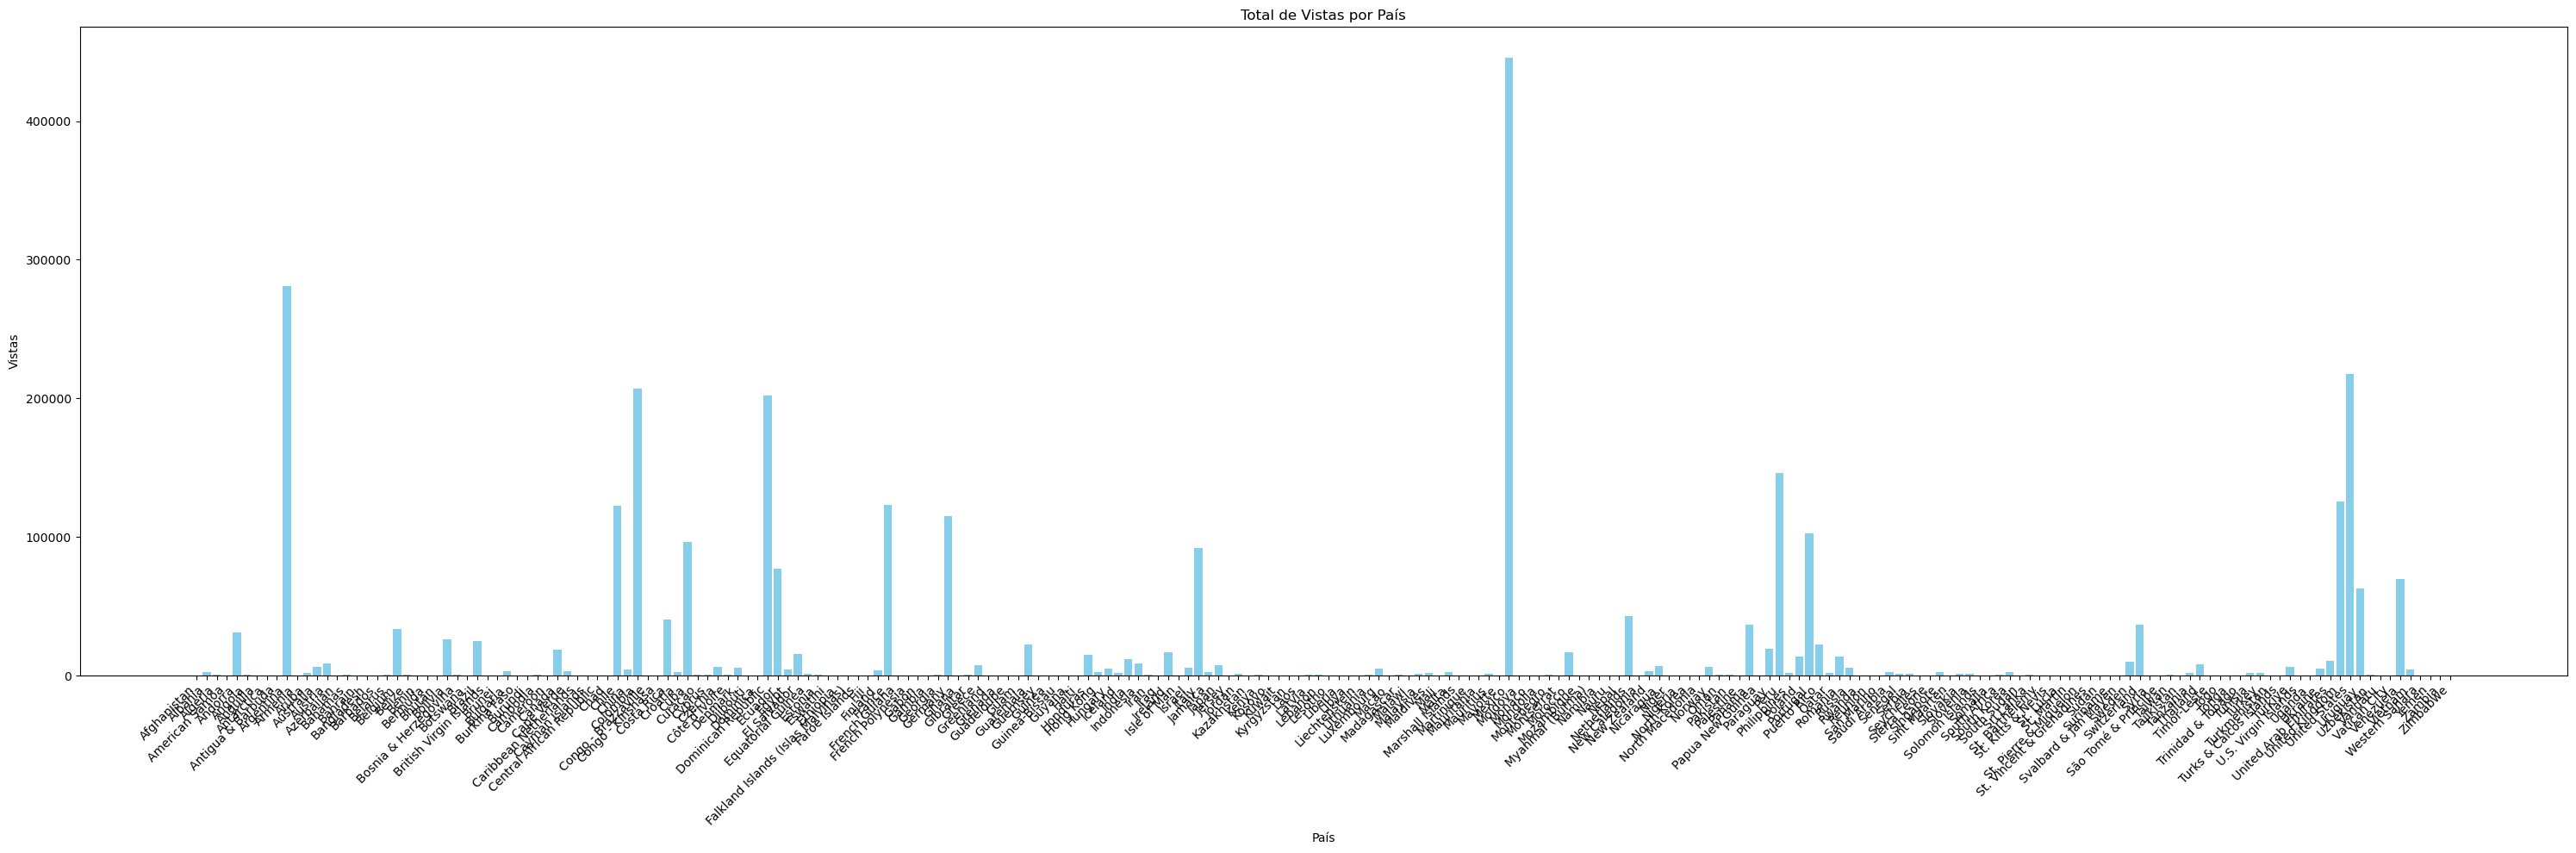

In [37]:
plot_views_by_region(df_noticias_pais, 'País', 'Vistas')

## Noticias por regiones de españa

In [19]:
df_noticias_region.id.value_counts()

id
156736    21
152133    21
158591    21
154580    21
149035    21
          ..
140608     1
138810     1
135519     1
135522     1
135292     1
Name: count, Length: 26200, dtype: int64

In [20]:
df_noticias_region.title.value_counts()

title
Las tres noticias más importantes del sector turístico hoy                    143
Un aeropuerto español entre los 10 del mundo con más tráfico internacional     38
Riu Plaza España, una experiencia inolvidable en el corazón de Madrid          38
Las tres noticias más importantes del sector turístico, hoy 29 de agosto       35
Las tres noticias más importantes del sector turístico, hoy 28 de agosto       35
                                                                             ... 
Los sindicatos aseguran que Air Europa prepara un ERTE por el coronavirus       1
¿Entrará en la lista verde del Reino Unido...el espacio?                        1
ObservaTUR califica de "parche" el sistema de bonos y pide ayudas directas      1
TSS Group lucha contra la inseguridad del coronavirus                           1
Baleares pide priorizar la vacunación en comunidades turísticas                 1
Name: count, Length: 26125, dtype: int64

In [21]:
df_noticias_region.slug.value_counts()

slug
156736_melia-lleva-su-propuesta-de-lujo-me-a-lisboa                                   21
152133_las-mejores-empresas-del-sector-turistico-para-trabajar                        21
158591_avoris-refuerza-su-operativa-para-diciembre-con-un-185-mas-de-plazas           21
154580_huelga-en-vueling-cuantos-dias-se-extiende-por-los-festivos                    21
149035_2021-el-ano-mas-seguro-para-la-aviacion-en-los-ultimos-cinco-anos              21
                                                                                      ..
140608_easyjet-registra-perdidas-por-1200m-y-planea-operar-al-20-este-invierno         1
138810_el-gobierno-entrega-a-las-ccaa-el-poder-de-implantar-el-estado-de-alarma        1
135519_canarias-pide-algun-hotel-abierto-para-los-turistas-que-no-puedan-salir         1
135522_agencias-de-sevilla-organizan-una-jornada-virtual-sobre-la-crisis-del-covid     1
135292_espana-y-portugal-cerraran-la-frontera-para-actividad-turistica-y-de-ocio       1
Name: count, Len

In [22]:
df_noticias_region.subcategory.value_counts()

subcategory
Actualidad turística                                     68437
Actualidad hotelera                                      52605
Actualidad e intermediación                              48699
Aperturas y cierres de hoteles                           17247
Actualidad                                               15690
Compañías aéreas                                         15211
Industria, business y nuevas tendencias                   8353
Aeropuertos                                               7599
Estadísticas e informes                                   6936
Innovación hotelera                                       6626
Gestión de destinos turísticos                            5858
Cruceros                                                  5657
Transacciones hoteleras                                   5606
Ferroviario                                               5442
Gestión hotelera                                          4026
Tendencias                                 

In [23]:
df_noticias_region.category.value_counts()

category
Hoteles y Alojamientos    101674
Economía                   87571
Distribución               62783
Transportes                60768
Innovación                 12997
Name: count, dtype: int64

<Axes: ylabel='count'>

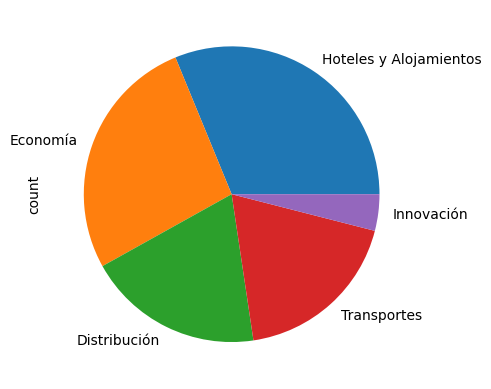

In [24]:
df_noticias_region.category.value_counts().plot(kind="pie")

In [25]:
df_noticias_region.published.value_counts()

published
2024-09-23    499
2022-10-04    471
2024-06-13    470
2025-01-21    467
2022-09-14    442
             ... 
2020-04-12      7
2020-06-20      6
2020-08-15      6
2020-09-20      5
2020-08-01      1
Name: count, Length: 1857, dtype: int64

In [26]:
df_noticias_region.published.describe()

count                           325793
mean     2023-01-29 16:16:02.319018752
min                2020-01-01 00:00:00
25%                2022-03-07 00:00:00
50%                2023-03-22 00:00:00
75%                2024-03-07 00:00:00
max                2025-01-31 00:00:00
Name: published, dtype: object

In [27]:
df_noticias_region.tags.value_counts()

tags
Noticias turismo hoy                                                                                                                                                                                                        1241
Publi Noticia Hosteltur                                                                                                                                                                                                     1163
Travelgate                                                                                                                                                                                                                   570
CONTENIDO PARA AAVV                                                                                                                                                                                                          431
Hosteltur Vídeos                                                                               

In [28]:
df_noticias_region["Región"].value_counts()

Región
Catalonia              23454
Andalusia              22739
Community of Madrid    22288
Valencian Community    21706
Balearic Islands       20923
Canary Islands         19644
Galicia                19467
Basque Country         19206
Castile and Leon       18446
Aragon                 17402
Castile-La Mancha      16425
Madrid                 15495
Asturias               15449
Region of Murcia       15227
Navarre                12411
Cantabria              12298
Extremadura            12146
La Rioja                9294
Murcia                  7983
Melilla                 2160
Ceuta                   1628
Nouvelle-Aquitaine         2
Name: count, dtype: int64

In [29]:
df_noticias_region["Vistas"].value_counts()

Vistas
1.0       53057
2.0       33122
3.0       22586
4.0       17580
5.0       13796
          ...  
3656.0        1
3885.0        1
3614.0        1
3344.0        1
2755.0        1
Name: count, Length: 2681, dtype: int64

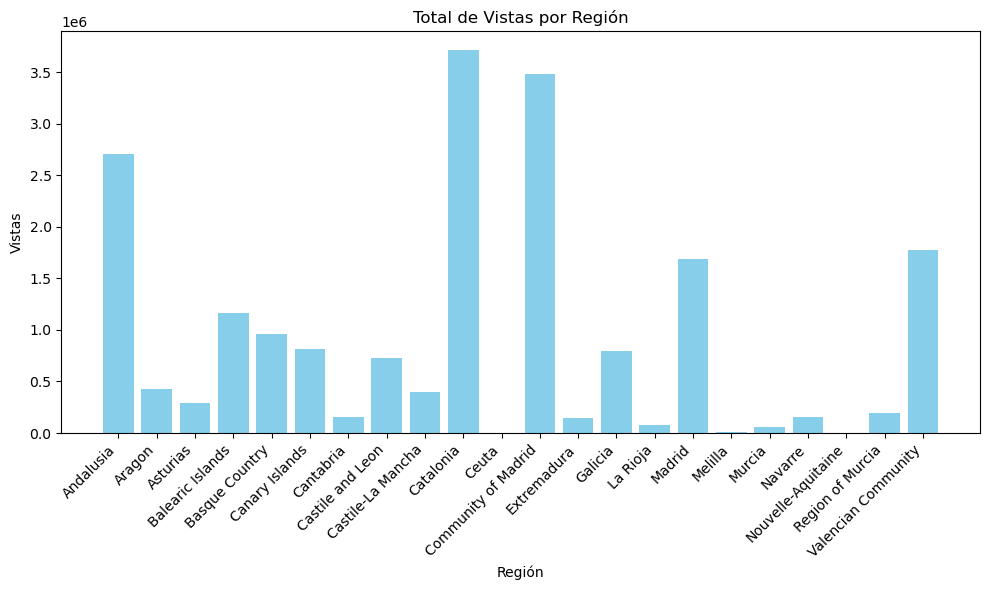

In [31]:
plot_views_by_regionpais(df_noticias_region, 'Región', 'Vistas')